In [1]:
import numpy as np
import sys
sys.path.insert(0, '../..') #This line adds '../..' to the path so we can import the net_framework python file
from RNN_model_GRAD import *
import matplotlib.pyplot as plt
import networkx as nx
import scipy.signal as sp
import random
import pickle
import tensorflow as tf
from tensorflow import keras

Generating and Visualizing our Network

In [ ]:
num_nodes = 1000
P_connection = .09
G = nx.random_geometric_graph(num_nodes, P_connection)
fig, ax = plt.subplots(figsize = [50,50])
options = {
    'node_color': 'black',
    'node_size': 40,
    'width': 0.2,
}

#nx.draw(G, **options)
plt.show()

initializing the recurrent network

In [ ]:
edges = np.asarray(G.edges())
edges = edges.astype('int32')
new_edges = []
for edge in edges:
    if np.random.uniform(0, 1) > 0.5:
        new_edge = [edge[1], edge[0]]
    else:
        new_edge = edge
    new_edges.append(new_edge)
edges = np.array(new_edges)
init_activations = np.random.uniform(-1, 1, num_nodes)
internal_weights_list = np.random.normal(0, 10/np.sqrt(num_nodes * P_connection), edges.shape[0])
weight_matrix = np.zeros((num_nodes, num_nodes))
connectivity_matrix = np.zeros((num_nodes, num_nodes))

i = 0
for edge in edges:
    weight_matrix[edge[0], edge[1]] = internal_weights_list[i]
    connectivity_matrix[edge[0], edge[1]] = 1
    i += 1
weight_matrix = tf.constant(weight_matrix)
connectivity_matrix = tf.constant(connectivity_matrix)
output_weight_matrix = tf.constant(np.random.normal(0, 1/np.sqrt(num_nodes), (1, num_nodes)))
where = tf.equal(connectivity_matrix, 0)
mask = np.zeros(weight_matrix.shape)
def input_func(t):
    return 0
input_funcs = [input_func]
input_weight_matrix = tf.constant(np.random.uniform(-1, 1, (num_nodes, 1)))


In [ ]:
network = RNN(weight_matrix, connectivity_matrix, init_activations,
              output_weight_matrix, timestep = 0.1)

In [ ]:
outputs, activations = network.simulate(250, input_funcs = input_funcs, input_weight_matrix = input_weight_matrix,)

In [ ]:
outputs = tf.transpose(outputs).numpy()[0]
fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.show()

In [ ]:
for i in range(4):
    fig, ax = plt.subplots()
    plt.plot(range(len(activations[:,i])), activations[:,i])
    plt.show()

In [17]:
num_nodes = 256
time_constant = 100 #ms
timestep = 20 #ms
noise_strength = .01
q = .5
num_inputs = 1
 
weight_matrix = tf.Variable(q * np.identity(num_nodes))
connectivity_matrix = tf.constant(np.ones((num_nodes, num_nodes)))

noise_weights = 0 * np.ones(num_nodes)
bias_weights = 0 * np.ones(num_nodes)
input_weights = np.random.normal(0, 1/np.sqrt(num_inputs), num_nodes)

input_weight_matrix = tf.constant(np.vstack((bias_weights, noise_weights, input_weights)).T)

def rule_input(time):
    #running for 5 seconds = 5000ms, input switches between 1 and 0 every second
    if time//1000 % 2 == 0:
        return 0
    else:
        return 1
def target_func(time):
    #running for 5 seconds = 5000ms, input switches between .2 and .8 every second.
    if time//1000 % 2 == 0:
        return .8
    else:
        return .2
    
def bias(time):
    return 1
def noise(time):
    return np.sqrt(2 * time_constant/timestep) * noise_strength * np.random.normal(0, 1)


input_funcs = [bias,noise, rule_input]

init_activations = np.zeros(num_nodes)
output_weight_matrix = tf.constant(np.random.uniform(0, 1/np.sqrt(num_nodes), (1, num_nodes)))
        
network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, time_constant = time_constant,
             timestep = timestep)

100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 1027.33it/s]


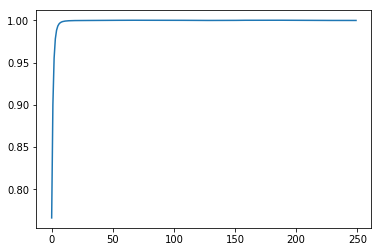

In [18]:
outputs, activations = network.simulate(time, input_funcs, input_weight_matrix)

outputs = tf.transpose(outputs).numpy()[0]
fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
#plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [23]:
num_iters = 100
time = 5000 #ms
regularizer = tf.keras.regularizers.L1(l1 = 0.0001)
network.train(num_iters, [target_func], time, num_trials = 1, input_funcs = input_funcs,
              input_weight_matrix = input_weight_matrix, learning_rate = 0.01, regularizer = regularizer)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

The loss is: tf.Tensor(0.3193337082646031, shape=(), dtype=float64) at iteration 0


 10%|████████                                                                         | 10/100 [00:02<00:16,  5.44it/s]

The loss is: tf.Tensor(0.3053564536017252, shape=(), dtype=float64) at iteration 10


 20%|████████████████▏                                                                | 20/100 [00:04<00:15,  5.21it/s]

The loss is: tf.Tensor(0.3063334349406629, shape=(), dtype=float64) at iteration 20


 30%|████████████████████████▎                                                        | 30/100 [00:06<00:12,  5.49it/s]

The loss is: tf.Tensor(0.30808791720431683, shape=(), dtype=float64) at iteration 30


 40%|████████████████████████████████▍                                                | 40/100 [00:07<00:10,  5.75it/s]

The loss is: tf.Tensor(0.30996745100091366, shape=(), dtype=float64) at iteration 40


 50%|████████████████████████████████████████▌                                        | 50/100 [00:09<00:09,  5.12it/s]

The loss is: tf.Tensor(0.31175865775738415, shape=(), dtype=float64) at iteration 50


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:11<00:07,  5.59it/s]

The loss is: tf.Tensor(0.3133971794042312, shape=(), dtype=float64) at iteration 60


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:13<00:05,  5.70it/s]

The loss is: tf.Tensor(0.3148712842889622, shape=(), dtype=float64) at iteration 70


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:15<00:03,  5.57it/s]

The loss is: tf.Tensor(0.31618654404594204, shape=(), dtype=float64) at iteration 80


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:17<00:01,  5.13it/s]

The loss is: tf.Tensor(0.3173521099540255, shape=(), dtype=float64) at iteration 90


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.17it/s]


array([<tf.Variable 'Variable:0' shape=(256, 256) dtype=float64, numpy=
array([[-0.00130826,  0.00192072,  0.00189907, ...,  0.00192186,
         0.00192159,  0.00192144],
       [ 0.00191297, -0.00131213,  0.00188354, ...,  0.00191487,
         0.00191451,  0.00191435],
       [-0.00198045, -0.00197983, -0.00139461, ..., -0.00197584,
        -0.00197664, -0.00197634],
       ...,
       [ 0.00075907,  0.00076032,  0.00033071, ..., -0.00136529,
         0.00077118,  0.00077389],
       [ 0.00091853,  0.00091972,  0.00056367, ...,  0.00093159,
        -0.00136241,  0.00093183],
       [ 0.0003678 ,  0.00036915, -0.00036962, ...,  0.00038572,
         0.00038301, -0.00137204]])>,
       <tf.Variable 'Variable:0' shape=(256, 256) dtype=float64, numpy=
array([[ 0.0048766 , -0.00427852, -0.00431076, ..., -0.00427663,
        -0.004277  , -0.00427681],
       [-0.00428847,  0.00487014, -0.00433142, ..., -0.00428559,
        -0.00428607, -0.00428579],
       [ 0.00419562,  0.00419625,  0.0047

In [27]:
outputs, activations = network.simulate(time, input_funcs, input_weight_matrix)

100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 1149.81it/s]


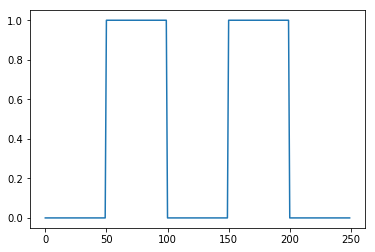

In [28]:

outputs = tf.transpose(outputs).numpy()[0]
fig, ax = plt.subplots()
#plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [rule_input(t * timestep) for t in range(len(outputs))])
plt.show()